In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi']=150

# Load scripts from parent path
import sys, os
sys.path.insert(0, os.path.abspath('..'))



## Load Data

In [3]:
# from scripts.processing_copy_Maryam import load_train_data, process_data, add_store_info, add_week_month_info, add_begginin
import scripts.processing as scr
train_raw = scr.load_train_data()
train = scr.add_week_month_info(train_raw)
train = scr.add_beginning_end_month(train)
train = scr.process_data(train)
train = scr.add_store_info(train)


# cols_to_drop = ['Open', 'StateHoliday', 'Assortment']
# train = train.drop(cols_to_drop, axis=1)

train.head()
#X_train, X_test, y_train, y_test = scr.prepare_data(train, test_size = 0.2)

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,week,month,end_of_month,beginning_of_month,StoreType,Assortment,CompetitionDistance,Store_Sales_mean,Store_Customers_mean
0,353.0,2.0,3139.0,1.0,0.0,a,1.0,1,1,0.000001,0.877078,b,b,900.0,4139.474576,1153.783333
1,335.0,2.0,2401.0,1.0,0.0,a,1.0,1,1,0.000001,0.877078,b,a,90.0,12845.896552,2384.271186
2,512.0,2.0,2646.0,1.0,0.0,a,1.0,1,1,0.000001,0.877078,b,b,590.0,3725.649123,888.627119
3,494.0,2.0,3113.0,1.0,0.0,a,1.0,1,1,0.000001,0.877078,b,a,1260.0,7079.150000,1010.583333
4,530.0,2.0,2907.0,1.0,0.0,a,1.0,1,1,0.000001,0.877078,a,c,18160.0,2260.783333,333.610169


## Prepare train/test data

In [4]:
X = train.copy(deep=True).drop(columns=["Sales"])
y = train.loc[:, "Sales"]

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Encoding features

In [6]:
import category_encoders as ce

#ord_enode = ce.OrdinalEncoder(cols=['Foreign_schooled',
 #                                    'Past_Disciplinary_Action','Previous_IntraDepartmental_Movement'])

#base_encode = ce.BaseNEncoder(cols=['State_Of_Origin','Marital_Status'])
# one_hot = ce.OneHotEncoder(cols=['StateHoliday'])
one_hot = ce.OneHotEncoder(cols=['StoreType', 'Assortment'])
# one_hot = ce.OneHotEncoder(cols=['StoreType'])
target_encode  = ce.TargetEncoder(cols = ['Store'])
ordinal_encode = ce.OrdinalEncoder(cols=['StateHoliday'])

/Users/frank/.local/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## RandomForestRegressor

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Drop date column too, makes no sense for random forest
X_train = train.copy(deep=True).drop(columns=["Sales"])
y_train = train.loc[:, "Sales"].values

# rfr = RandomForestRegressor(max_depth=1)
rfr = RandomForestRegressor(max_depth=20, criterion="squared_error")

#build the pipeline
pipe = Pipeline(steps=[
                ('onehot_encode', one_hot),
                ('ordinal_encode', ordinal_encode), 
                ('target_encode', target_encode),
                ('model', rfr)]
                )

pipe.fit(X_train, y_train)

/Users/frank/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/frank/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/frank/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


KeyboardInterrupt: 

In [7]:
from scripts.processing import metric

y_pred_train = pipe.predict(X_train)
y_pred = pipe.predict(X_test)
# metric(y_train, y_pred_train)
metric(y_test.values, y_pred)


NameError: name 'pipe' is not defined

### Save/Load model

In [8]:
from scripts.pipeline import save_pipeline, load_pipeline

# save_pipeline(pipe, name='random_forest_advanced_test')
# save_pipeline(pipe, name='random_forest_advanced_monthend')

# pipe = load_pipeline(name='random_forest_advanced_test')

## Model Evaluation

### Compare predictions and data

In [37]:
from scripts.evaluation import compare_predictions_and_sales_per_date

result = compare_predictions_and_sales_per_date(y_pred=y_pred_train, y_actual=y_train)
result

,Date,pred,actual,error,error_abs
0,2013-01-01,9.969986e+04,87980.0,-13.321049,13.321049
1,2013-01-02,5.532516e+06,5540964.0,0.152472,0.152472
2,2013-01-03,5.027985e+06,4968668.0,-1.193814,1.193814
3,2013-01-04,5.508519e+06,5485577.0,-0.418218,0.418218
4,2013-01-05,4.870689e+06,4755084.0,-2.431186,2.431186
...,...,...,...,...,...
572,2014-07-27,1.850795e+05,201300.0,8.057865,8.057865
573,2014-07-28,7.088558e+06,6994114.0,-1.350339,1.350339
574,2014-07-29,6.021770e+06,5989282.0,-0.542439,0.542439
575,2014-07-30,6.244718e+06,6021459.0,-3.707723,3.707723


In [36]:
# # Compare sales
# dates = pd.DataFrame(scr.process_data(train_raw, drop_null=True, drop_date=False).loc[:, 'Date'])

# sales = dates.copy()
# sales.loc[:, 'pred'] = y_pred_train
# sales.loc[:, 'actual'] = y_train


# sales = sales.groupby(by='Date').sum().reset_index()

# sales.loc[:,'weekday'] = sales.loc[:, 'Date'].dt.weekday

# sales

In [35]:
# def metric_not_summed(preds, actuals):
#     preds = preds.reshape(-1)
#     actuals = actuals.reshape(-1)
#     assert preds.shape == actuals.shape
#     # return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])
#     # return 100 * np.abs((actuals - preds) / actuals)
#     return 100 * (actuals - preds) / actuals

# sales.loc[:, 'error'] = metric_not_summed(sales.loc[:, 'pred'].values, sales.loc[:, 'actual'].values)
# sales.loc[:, 'error_abs'] = np.abs(sales.loc[:, 'error'])

In [38]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=result['Date'], y=result['actual'],
                    mode='lines+markers',
                    name='actual'))

fig.add_trace(go.Scatter(x=result['Date'], y=result['pred'],
                    mode='lines',
                    name='predicted'))
# Edit the layout
fig.update_layout(title='Sales over Time - Prediction of Final Model vs. Actual',
                   xaxis_title='Date',
                   yaxis_title='Total Sales')
fig.show()

In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sales['Date'], y=sales['error'],
                    mode='markers',
                    name='actual'))

fig.update_layout(title='Error over Time',
                   xaxis_title='Date',
                   yaxis_title='Error')

fig.show()

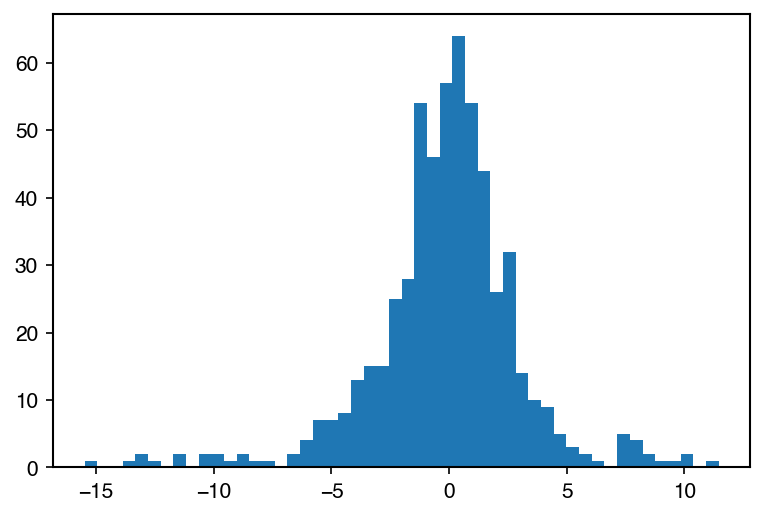

In [22]:
plt.hist(sales['error'],bins=50)
plt.show()

In [135]:
sales

,Date,pred,actual,weekday,error,error_abs
0,2013-01-01,1.195249e+05,87980.0,1,-35.854611,35.854611
1,2013-01-02,5.005502e+06,5540964.0,2,9.663703,9.663703
2,2013-01-03,4.905868e+06,4968668.0,3,1.263917,1.263917
3,2013-01-04,5.557137e+06,5485577.0,4,-1.304507,1.304507
4,2013-01-05,4.989026e+06,4755084.0,5,-4.919832,4.919832
...,...,...,...,...,...,...
572,2014-07-27,2.029447e+05,201300.0,6,-0.817035,0.817035
573,2014-07-28,7.603074e+06,6994114.0,0,-8.706752,8.706752
574,2014-07-29,6.459785e+06,5989282.0,1,-7.855750,7.855750
575,2014-07-30,5.948941e+06,6021459.0,2,1.204329,1.204329


In [136]:
sales.groupby(by='weekday').mean()

,pred,actual,error,error_abs
weekday,,,,
0,6.802598e+06,6.849323e+06,0.458313,5.242119
1,6.133694e+06,6.079564e+06,-2.200232,6.422667
2,5.696635e+06,5.685448e+06,-1.181402,6.319649
3,5.479929e+06,5.445729e+06,-0.624234,6.240356
4,5.924831e+06,6.001493e+06,0.714804,6.265938
5,5.162723e+06,5.144844e+06,-1.163061,5.879601
6,1.692082e+05,1.671312e+05,-1.440031,8.239879


1.284129976470486

0         0.000001
1         0.000001
2         0.000001
3         0.000001
4         0.000001
            ...   
637769    1.000000
637770    1.000000
637771    1.000000
637772    1.000000
637773    1.000000
Name: Date, Length: 637774, dtype: float64

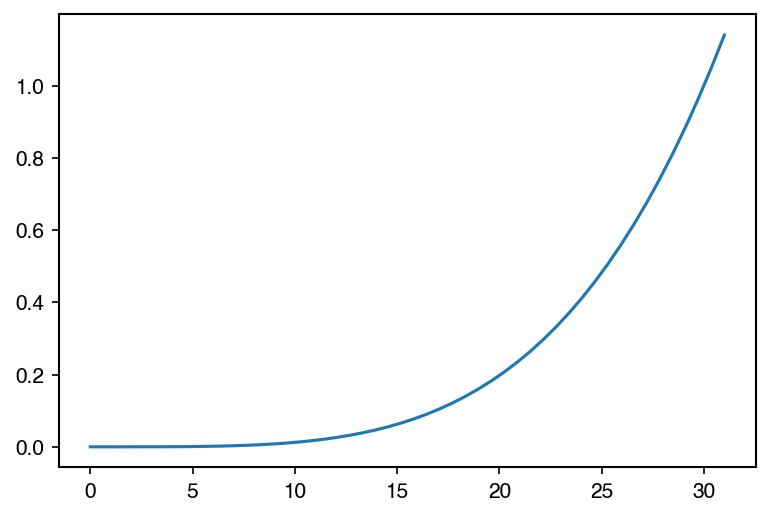

In [70]:
x = np.linspace(0,31,50)

# y = ((30-x)/30)**4
y = (x/30)**4
plt.plot(x,y)


In [21]:
y_pred_train = pipe.predict(X_train)


## LGBM

In [25]:
from lightgbm import LGBMRegressor

from sklearn.pipeline import Pipeline
from scripts.processing import metric

# Drop date column too, makes no sense for random forest
X_train = train.copy(deep=True).drop(columns=["Sales"])
X_train.loc[:, 'week'] = X_train.loc[:, 'week'].astype(int)
X_test.loc[:, 'week'] = X_test.loc[:, 'week'].astype(int)

y_train = train.loc[:, "Sales"].values

# rfr = RandomForestRegressor(max_depth=1)
# rfr = RandomForestRegressor(max_depth=20, criterion="squared_error")
reg = LGBMRegressor(n_estimators=500)

#build the pipeline
pipe_lgbm = Pipeline(steps=[
                ('onehot_encode', one_hot),
                ('ordinal_encode', ordinal_encode), 
                ('target_encode', target_encode),
                ('model', reg)]
                )

pipe_lgbm.fit(X_train, y_train)

y_pred_train = pipe_lgbm.predict(X_train)
y_pred = pipe_lgbm.predict(X_test)
# metric(y_train, y_pred_train)
metric(y_test.values, y_pred)


/Users/frank/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.

/Users/frank/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.

/Users/frank/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.



12.395757315072032

In [159]:
from scripts.pipeline import save_pipeline

save_pipeline(pipe_lgbm, name='lightgbm_cv')

 - Saving pipeline "lightgbm_first" at:
../data/trained_pipelines/pipeline_lightgbm_first.p


In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426787 entries, 0 to 426786
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Store                 426787 non-null  float64
 1   DayOfWeek             426787 non-null  float64
 2   Open                  426787 non-null  float64
 3   Promo                 426787 non-null  float64
 4   StateHoliday          426787 non-null  object 
 5   SchoolHoliday         426787 non-null  float64
 6   week                  426787 non-null  int64  
 7   month                 426787 non-null  int64  
 8   end_of_month          426787 non-null  float64
 9   beginning_of_month    426787 non-null  float64
 10  StoreType             426787 non-null  object 
 11  Assortment            426787 non-null  object 
 12  CompetitionDistance   426787 non-null  float64
 13  Store_Sales_mean      426787 non-null  float64
 14  Store_Customers_mean  426787 non-null  float64
dtype

## Plot Residuals

In [47]:
len(train_raw)

637774

In [44]:
len(y_train)

426787

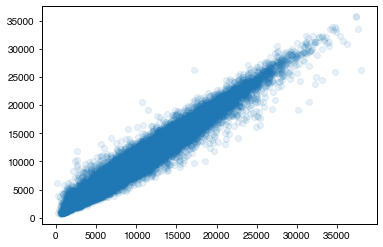

In [43]:
plt.scatter(y_train, y_pred_train, alpha=0.1)
plt.show()

In [17]:
from scripts.

In [18]:
metric(y_test.values, y_pred_test)

6.788199236021356

In [19]:
from scripts.pipeline import save_pipeline

save_pipeline(pipe, name='random_forest_winner')

 - Saving pipeline "random_forest_winner" at:
../data/trained_pipelines/pipeline_random_forest_winner.p


## Simple Models

#### Predict mean

In [ ]:
y_train_withPred =  pd.DataFrame(y_train.copy())
y_test_withPred =  pd.DataFrame(y_test.copy())

y_train_withPred.loc[:,'Sales_pred'] = y_train.mean()
y_test_withPred.loc[:,'Sales_pred']  = y_train.mean()

In [ ]:
metric(y_test_withPred.loc[:,'Sales_pred'].values, y_test.values)